In [1]:
import spacy
import pandas as pd
import numpy as np
from glob import glob
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from numpy.random import randint
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.manifold import TSNE
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

In [2]:
class textPieces(): 
    def __init__(self, author, sample=True, pieces=2): 
        self.author = author
        self.filenames = glob('data/%s*' % author)
        #print('Using filenames: ', self.filenames)
        self.texts = [open(filename, errors="ignore").read() 
                 for filename in self.filenames]
        self.lengths = [len(text) for text in self.texts]
        self.lowestLength = min(self.lengths)
        if sample: 
            self.samples = [self.sample(text) for text in self.texts]
        else: 
            self.samples = self.texts
        if pieces > 1: 
            self.labels = []
            self.pieces = []
            self.makePieces(self.filenames, self.samples, 2)
        else: 
            self.labels = [filename[6+len(self.author):-4] for filename in self.filenames]
            self.pieces = self.texts
        
    def sample(self, text): 
        """ Randomly samples from texts that are long, 
        so that we're comparing the same amount of text across documents."""
        chunkSize = self.lowestLength
        # We want a chunk of [a:b] where the max value of b is end-chunkSize
        textLength = len(text)
        maxEnd = textLength - chunkSize
        if maxEnd <= 0: 
            #print('Something went wrong. maxEnd is negative or zero.')
            return text
        start = randint(0, maxEnd)
        return text[start:start+chunkSize]
    
    def makePieces(self, filenames, samples, n): 
        pieceSize = self.lowestLength / n
        for filename, sample in zip(filenames, samples): 
            for i in range(n):
                label = filename[6+len(self.author):-4] # Cut off 'data/cather-' for example and .txt
                pieceLabel = "%s-%s" % (label, i)
                start = int(i*pieceSize)
                end = int(start+pieceSize)
#                 print('Piece start: %s, piece end: %s' % (start, end))
                piece = sample[start:end]
                self.labels.append(pieceLabel)
                self.pieces.append(piece)

In [3]:
class authorAnalysis(): 
    def __init__(self, labels, docs): 
        self.labels = labels
        self.docs = docs
        self.features, self.matrix = self.vectorize()
        # Assume the date is the first four characters of the label. 
        self.pieceDates = [int(label[:4]) for label in self.labels]
        # Try to assign "early," "middle," and "late" categories (0, 1, 2) based on years. 
        self.categories = [round(cat) for cat in self.rescale(self.pieceDates, 0, 2)]
        
    #@property
    #def categories(): 
    #    pass
        
    def vectorize(self): 
        tfidf = TfidfVectorizer(use_idf=False, max_features=800)
        matrix = tfidf.fit_transform(self.docs).todense()
        features = tfidf.get_feature_names()
        return features, matrix
    
    def vectorDF(self):
        """ Just a helper to visualize the TFIDF table."""
        return pd.DataFrame(self.matrix, columns=self.features, index=self.labels)
    
    def doPCA(self): 
        pca = PCA(n_components=5)
        return pca.fit_transform(self.matrix)
    
    def doTSNE(self): 
        tSNE = TSNE(n_components=2)
        return tSNE.fit_transform(self.matrix)
        
    def plotPCA(self, tSNE=False, labels=True, saveTo=False, clustering='bgm'): 
        if tSNE: 
            pcaTable = self.doTSNE()
        else: 
            pcaTable = self.doPCA()
        Xs = [thing[0] for thing in pcaTable]
        Ys = [thing[1] for thing in pcaTable]
        df = pd.DataFrame(pcaTable, index=self.labels)
        #df['distance'] = np.sqrt(df[0]**2 + df[1]**2)     # Pythagorean theorem   
        df['distance'] = df.apply(np.linalg.norm, axis=1)
        if clustering == 'kmeans': 
            colors = self.kmeans()
        if clustering == 'bgm': 
            colors = self.bgm()
        df['bgm'] = self.bgm()
        df['initCats'] = self.categories
        df['pubDate'] = self.pieceDates
        ax = plt.scatter(df[0], df[1], s=self.size, c=colors)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        if labels: 
            for i, label in enumerate(self.labels):
                plt.annotate(label, (Xs[i], Ys[i]))
        if saveTo: 
            fig = ax.get_figure()
            fig.tight_layout()
            fig.savefig('results/pca-' + saveTo + '.png') # save it to a file
        return df.sort_values('distance', ascending=False)
    
    def rescale(self, array, low, high):
        minimum = min(array)
        maximum = max(array)
        diff = maximum - minimum
        diffScale = high - low
        return list(map( lambda x: (int(x)-minimum)*(diffScale/diff)+low, array))
    
    @property
    def size(self, by='date'): 
        if by == 'date': 
            return self.rescale(self.pieceDates, 20, 500)

    def kmeans(self): 
        pcaOut = self.doPCA()
        kmeans = KMeans(n_clusters=3)
        return kmeans.fit_predict(pcaOut)
    
    def bgm(self): 
        pcaOut = self.doPCA()
        bgm = BayesianGaussianMixture(n_components=3).fit(pcaOut)
        return bgm.predict(pcaOut)
        
    def lateCatEarlyCat(self): 
        """ Find the bgm-predicted category with the latest works, and the earliest."""
        catsDict = {} # Contains total dates per initial category
        for i in range(3):
            # Sum all the dates
            catsDict[i] = df.loc[df['bgm'] == i]['pubDate'].mean()
        #print(catsDict)
        return max(catsDict, key=catsDict.get), min(catsDict, key=catsDict.get)
    
    def metrics(self): 
        randK = adjusted_rand_score(self.categories, self.kmeans())
        randB = adjusted_rand_score(self.categories, self.bgm())
        #print('Adjusted rand score, Kmeans: ', randK)
        print('Periodicity: Adjusted rand score, BGM: ', randB)
        randK = adjusted_mutual_info_score(self.categories, self.kmeans())
        randB = adjusted_mutual_info_score(self.categories, self.bgm())
        #print('Adjusted mutual info score, Kmeans: ', randK)
        #print('Adjusted mutual info score, BGM: ', randB)
        print('Lateness: ', self.lateness())
        #print('TDD-Lateness: ', self.tddLateness())
        
    def periodicity(self): 
        return adjusted_rand_score(self.categories, self.bgm())
    
    def categorize(self, cats):
        pointsDict = {cat: [] for cat in set(cats)}
        for point, cat in zip(self.doPCA(), cats):
            pointsDict[cat].append(point)
        return pointsDict
                              
    def categorizeBGM(self):
        return self.categorize(self.bgm())
    
    def categorizePoints(self):
        return self.categorize(self.categories)
    
    def categorizeTdd(self):
        return self.categorize(self.tddCats)
    
    def centroids(self, cats): 
        centroidsDict = {}
        for key, val in cats.items():
            centroid = np.mean(val, axis=0)
            centroidsDict[key] = centroid
        return centroidsDict
    
    def centroidsBGM(self): 
        return self.centroids(self.categorizeBGM())
    
    def centroidsCats(self): 
        #print('categorized points: ', self.categorizePoints())
        return self.centroids(self.categorizePoints())
        
    def centroidsTddCats(self):
        return self.centroids(self.categorizeTdd())
    
    def lateDistinctiveness(self): 
        #lateCat = self.lateCatEarlyCat()[0]
        return np.linalg.norm(self.centroidsCats()[2])
    
    def earlyDistinctiveness(self):
        #earlyCat = self.lateCatEarlyCat()[1]
        #print(self.centroidsCats())
        #print(self.bgm())
        return np.linalg.norm(self.centroidsCats()[0])
    
    def lateness(self):
        return self.lateDistinctiveness() - self.earlyDistinctiveness()
    
    def lateDistinctivenessTdd(self):
        if 2 in self.centroidsTddCats(): 
            return np.linalg.norm(self.centroidsTddCats()[2])
        else:
            return 0
    
    def earlyDistinctivenessTdd(self):
        if 0 in self.centroidsTddCats():
            return np.linalg.norm(self.centroidsTddCats()[0])
        else:
            return 0
    
    def tddLateness(self):
        return self.lateDistinctivenessTdd() - self.earlyDistinctivenessTdd()

In [4]:
authorTable = {}

In [5]:
def doAnalysis(author, nIterations=10):  
    latenesses = []
    periodicities = []
    print('Lateness: ')
    for i in range(nIterations): 
        pieces = textPieces(author)
        analysis = authorAnalysis(pieces.labels, pieces.pieces)
        print('{}: {}'.format(i, analysis.lateness()), end=' ')
        latenesses.append(analysis.lateness())
        periodicities.append(analysis.periodicity())
    df = analysis.plotPCA(saveTo=author)
    print()
    print(analysis.metrics())
    averageLateness = sum(latenesses)/len(latenesses)
    print('Average lateness: ', averageLateness)
    averagePeriodicity = sum(periodicities)/len(periodicities)
    print('Average periodicities: ', averagePeriodicity)
    #latecat, earlycat = analysis.lateCatEarlyCat()
    #print("Latecat: {}, earlycat: {}".format(latecat, earlycat))
    authorTable[author] = {'mean lateness': averageLateness, 'mean periodicity': averagePeriodicity}
    return df

# Proust

Lateness: 
0: -0.1115208811764049 1: -0.1144779929456009 2: -0.07464355938830723 3: -0.0961671983700946 4: -0.10754858463462257 5: -0.1074172245775306 6: -0.09700786906186898 7: -0.04532415593597015 8: -0.08973898131547323 9: -0.09675454526309914 
Periodicity: Adjusted rand score, BGM:  0.1546572934973638
Lateness:  -0.09675454526309926
None
Average lateness:  -0.09406009926689723
Average periodicities:  0.13530917135703108


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1913-swann-1,0.281185,0.070914,-0.065637,0.010148,0.011933,0.297737,2,0,1913
1925-albertine-0,-0.130815,0.166397,-0.067092,0.012774,0.010329,0.222647,0,2,1925
1927-retrouve-0,0.030472,-0.097604,0.026941,0.082593,-0.018345,0.135421,1,2,1927
1927-retrouve-1,-0.063177,-0.092571,-0.059543,0.034274,0.025842,0.133972,1,2,1927
1920-guermantes-1,-0.010094,-0.079522,0.027211,-0.029569,0.092377,0.128740,1,1,1920
1919-lombre-1,-0.086848,-0.051695,-0.057916,-0.004568,-0.043930,0.124579,1,1,1919
1923-prisonniere-1,-0.028719,0.072007,0.066802,0.036371,-0.013922,0.109495,1,1,1923
1920-guermantes-0,0.026174,0.044499,0.063878,-0.051330,-0.029220,0.101165,1,1,1920
1919-lombre-0,0.010855,-0.073916,-0.000132,-0.057564,-0.036072,0.100976,1,1,1919
1913-swann-0,0.024264,-0.060097,-0.037734,-0.052556,-0.025707,0.095117,1,0,1913


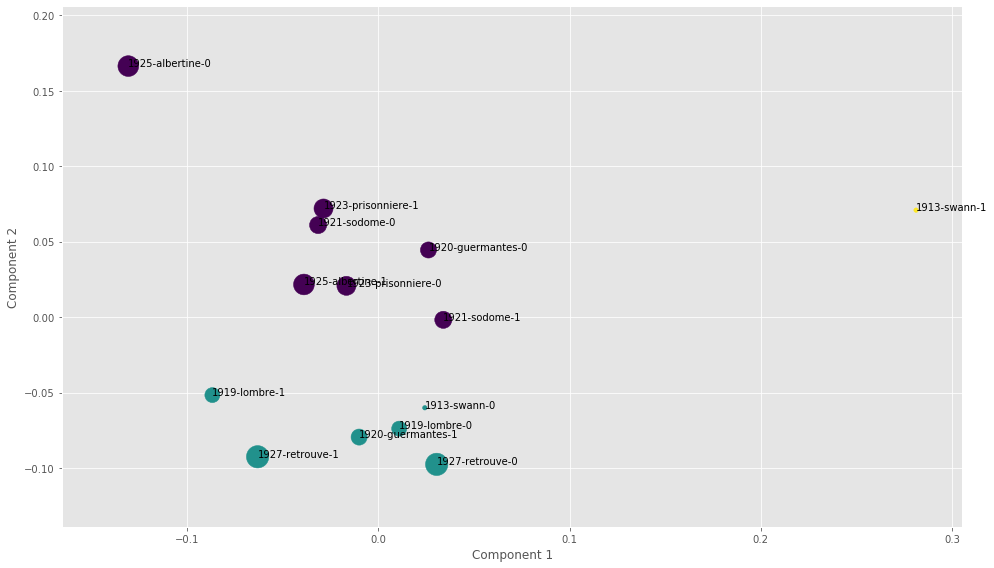

In [6]:
doAnalysis('proust')

# Dickens

Lateness: 
0: 0.011056778036815554 1: 0.005735780608096139 2: 0.02783821932527719 3: 0.009323142569807541 4: 0.0010581468162085828 5: 0.012681512199375355 6: 0.04443038935769965 7: -0.009921860383949571 8: 0.019510243568546526 9: 0.012215761278488044 
Periodicity: Adjusted rand score, BGM:  0.19342729413370646
Lateness:  0.012220173305801413
None
Average lateness:  0.013391691118924059
Average periodicities:  0.18099031688488781


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1837-the-pickwick-papers-0,-0.195466,0.140761,0.100730,-0.041960,0.022088,0.265359,1,0,1837
1850-david-copperfield-1,0.215133,-0.041734,0.103134,-0.027976,-0.003328,0.243833,0,1,1850
1837-the-pickwick-papers-1,-0.168372,0.124125,0.098734,-0.021633,-0.001855,0.232328,1,0,1837
1850-david-copperfield-0,0.183162,-0.031429,0.116668,-0.058531,0.005169,0.227157,0,1,1850
1853-bleak-house-0,0.139234,0.091261,-0.036421,0.036188,-0.091125,0.196607,2,1,1853
1839-oliver-twist-0,-0.180323,0.008890,0.035105,-0.002296,0.024338,0.185541,1,0,1839
1841-the-old-curiosity-shop-0,-0.119406,-0.123139,0.030116,0.034699,-0.022500,0.178992,1,0,1841
1848-dombey-and-son-1,0.007669,-0.081172,0.074480,0.123605,-0.014105,0.166350,0,1,1848
1841-barnaby-rudge-1,-0.116578,-0.080588,-0.067347,-0.026017,-0.027735,0.161452,1,0,1841
1853-bleak-house-1,0.143061,0.032805,-0.001759,-0.031801,-0.053184,0.159328,0,1,1853


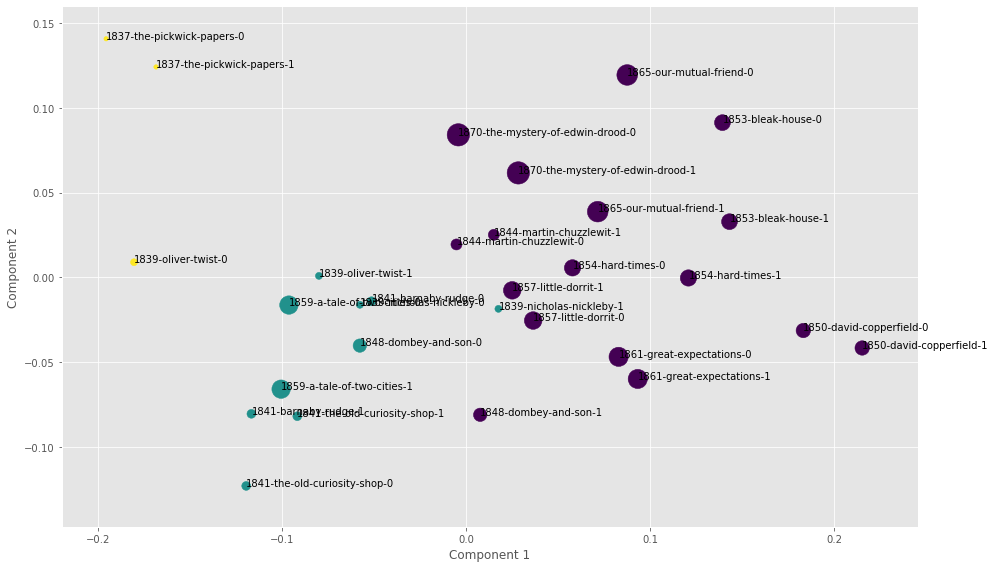

In [7]:
doAnalysis('dickens')

# Conrad

Lateness: 
0: 0.003207966615650565 1: 0.019685038746957234 2: 0.01371753878630548 3: 0.0067389435022846556 4: 0.03547422498873197 5: -0.004417345088861074 6: 0.047098411096943765 7: -0.013779112453144837 8: 0.015482895456600601 9: 0.005646869132667862 
Periodicity: Adjusted rand score, BGM:  0.28273399892406254
Lateness:  0.005648966124267213
None
Average lateness:  0.012891207488181705
Average periodicities:  0.12752602100435198


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1919-the-arrow-of-gold-1,0.297362,0.106726,0.101384,0.100816,0.027821,0.347895,2,2,1919
1919-the-arrow-of-gold-0,0.234930,0.026385,0.042239,0.027116,-0.046499,0.246109,2,2,1919
1913-chance-1,0.208402,0.065747,-0.101920,-0.036809,-0.013607,0.244299,1,1,1913
1897-the-nigger-of-the-narcissus-1,-0.136872,0.087588,0.138597,-0.086289,-0.074580,0.242121,0,0,1897
1895-almayers-folly-0,-0.156898,0.087310,-0.027356,0.147245,0.033681,0.236229,0,0,1895
1895-almayers-folly-1,-0.129109,0.124460,-0.012336,0.062132,0.059139,0.199172,0,0,1895
1897-the-nigger-of-the-narcissus-0,-0.157763,0.063492,0.093460,-0.028017,-0.030325,0.198393,0,0,1897
1896-an-outcast-of-the-islands-1,-0.009767,0.158823,-0.091777,-0.024488,-0.016048,0.186012,1,0,1896
1911-under-western-eyes-1,0.169803,0.019867,-0.001353,0.054560,0.032231,0.182333,2,1,1911
1917-the-shadow-line-1,0.048703,-0.117976,0.121211,0.003933,0.037146,0.179938,0,1,1917


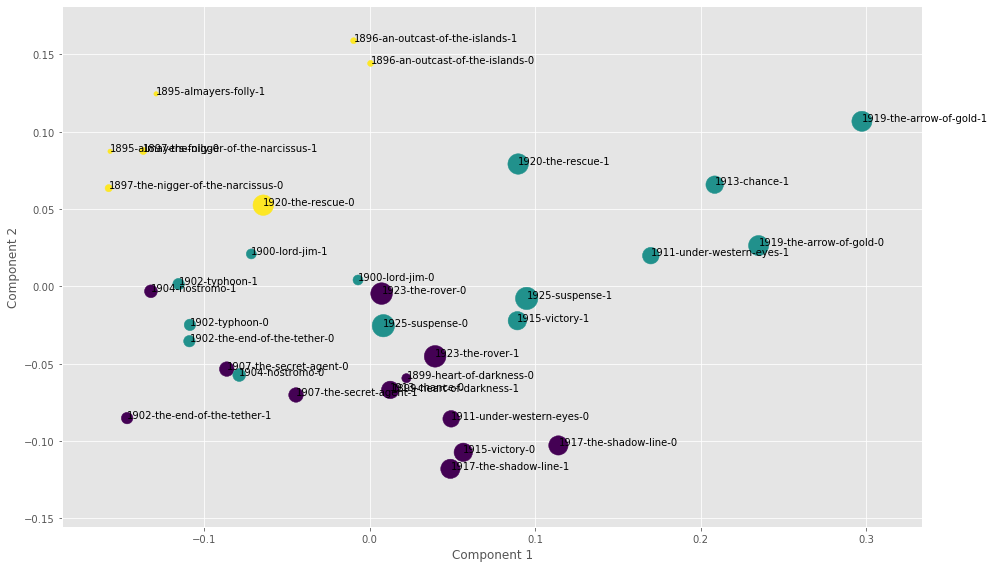

In [8]:
doAnalysis('conrad') 

# Jean Genet

Lateness: 
0: 0.15189816428943362 1: 0.15020027821889576 2: 0.16385334053075354 3: 0.15170077484140393 4: 0.15616196209280306 5: 0.15217859124171723 6: 0.15190614343212047 7: 0.14419010017680248 8: 0.16698166869043463 9: 0.14768265519945678 
Periodicity: Adjusted rand score, BGM:  -0.07142857142857147
Lateness:  0.14768265519945706
None
Average lateness:  0.15367536787138206
Average periodicities:  0.11255148708916854


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1947-querelle-de-brest-1,0.189725,-0.096732,-0.057396,-0.070799,-0.031161,0.233732,0,0,1947
1947-querelle-de-brest-0,0.210026,-0.051035,-0.062974,0.007500,0.008820,0.225422,0,0,1947
1949-journal-du-voleur-1,-0.146159,-0.135551,0.025671,-0.037305,-0.049181,0.210253,1,0,1949
1949-journal-du-voleur-0,-0.182871,-0.075287,0.015739,0.006651,-0.049602,0.204603,1,0,1949
1986-captif-amoreux-1,-0.084420,0.158923,-0.089002,-0.006742,-0.015401,0.201462,2,2,1986
1942-notre-dame-1,0.077866,0.120756,0.093591,-0.037125,-0.009639,0.175715,2,0,1942
1986-captif-amoreux-0,-0.076237,0.129067,-0.071770,0.014927,-0.025226,0.168761,2,2,1986
1942-notre-dame-0,0.079892,0.092519,0.113016,-0.017685,-0.010056,0.167717,2,0,1942
1946-miracle-de-la-rose-0,-0.092459,-0.033824,0.000553,-0.036655,0.090128,0.138419,2,0,1946
1947-pompes-funèbres-0,0.034096,-0.078270,0.031974,0.088141,-0.003763,0.126863,2,0,1947


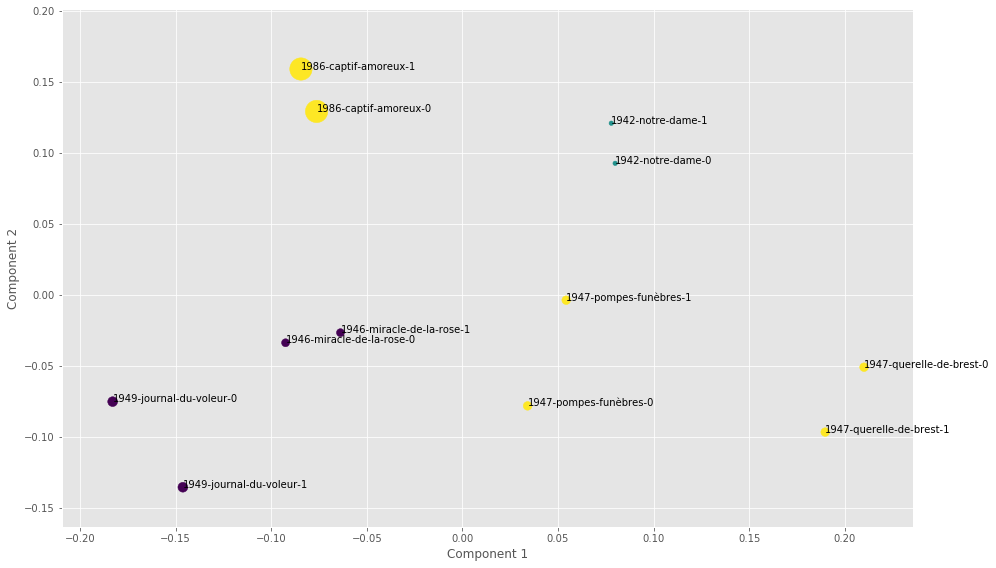

In [9]:
doAnalysis('genet')

# James

Lateness: 
0: 0.0722139953352303 1: 0.07592371990541326 2: 0.06094260340450766 3: 0.06361011143763869 4: 0.06103339456002438 5: 0.056057505420693474 6: 0.06577649104518676 7: 0.054246193520534836 8: 0.05467661509026826 9: 0.055283930779033735 
Periodicity: Adjusted rand score, BGM:  0.26402796540534523
Lateness:  0.05528404705256319
None
Average lateness:  0.06197010604876493
Average periodicities:  0.3154140674218021


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1901-sacred-found-1,0.038740,0.175830,0.034825,-0.113467,0.137774,0.255903,1,1,1901
1877-the-american-0,-0.203972,-0.097192,0.011348,-0.086719,0.065973,0.251102,2,0,1877
1911-outcry-1,-0.170626,0.153727,0.024788,0.063224,-0.059012,0.246656,0,2,1911
1877-the-american-1,-0.171346,-0.122559,0.041625,-0.112463,0.008283,0.242548,2,0,1877
1886-bostonians-1,0.207819,-0.088459,-0.035801,-0.055656,-0.018924,0.236117,1,1,1886
1886-bostonians-0,0.217139,-0.085438,-0.021420,-0.015589,-0.015450,0.235350,1,1,1886
1902-wings-of-the-dove-0,0.232533,0.023129,0.012265,0.005180,0.023816,0.235268,1,1,1902
1880-washington-square-1,-0.019537,-0.159415,0.134178,0.082882,0.063255,0.233815,2,0,1880
1897-spoils-poynton-1,0.136036,-0.061937,0.167973,0.037833,0.000401,0.228009,1,1,1897
1897-spoils-poynton-0,0.218916,-0.037080,-0.018805,-0.000451,-0.007680,0.222962,1,1,1897


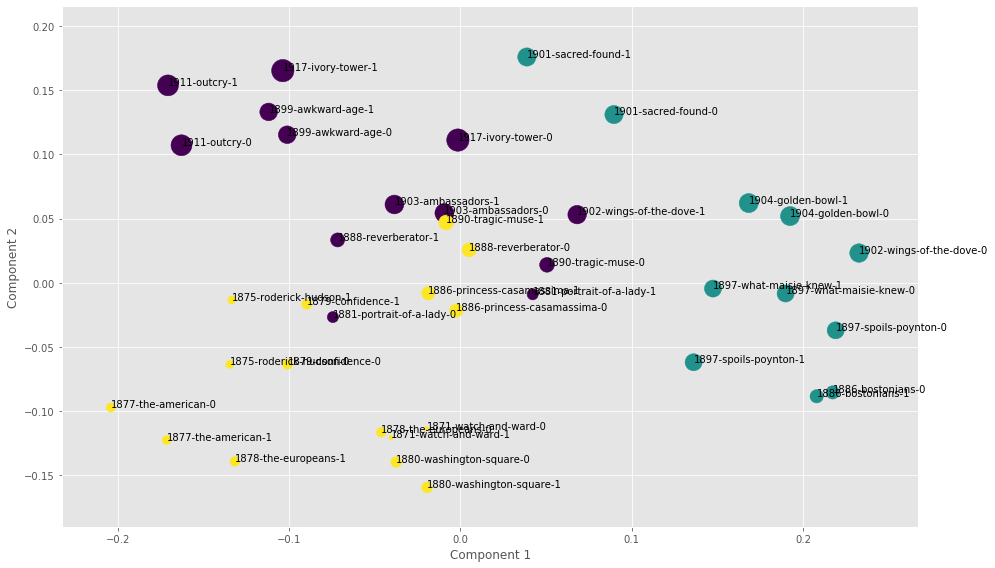

In [10]:
doAnalysis('james')

# Mann

Lateness: 
0: 0.16152179171178654 1: 0.21199964123733 2: 0.15796127948548697 3: 0.17977107151784671 4: 0.20479733267149478 5: 0.1767410706637471 6: 0.1617568084630696 7: 0.19603938634010454 8: 0.21893382629845348 9: 0.21858339986356423 
Periodicity: Adjusted rand score, BGM:  -0.15256124721603562
Lateness:  0.2185833998635639
None
Average lateness:  0.1888105608252885
Average periodicities:  0.048754435753344295


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1897-kleine-herr-0,0.339657,-0.174688,-0.134160,0.068936,0.130172,0.430788,0,0,1897
1897-kleine-herr-1,0.256351,-0.188981,-0.140385,0.118927,-0.085880,0.377699,0,0,1897
1903-tristan-0,0.210652,0.300281,0.028502,-0.058327,0.006540,0.372559,2,0,1903
1943-doktor-1,0.041672,-0.224438,0.263380,-0.031698,0.023617,0.350771,1,2,1943
1903-tonio-0,0.310222,0.063557,-0.002919,-0.143985,0.032452,0.349386,2,0,1903
1912-tod-0,-0.295199,-0.049894,-0.061366,-0.005463,0.080645,0.316119,1,1,1912
1912-tod-1,-0.282643,-0.067318,-0.007094,-0.064177,0.078426,0.307796,1,1,1912
1909-königliche-0,-0.059086,0.156174,0.144836,0.184240,0.036657,0.290081,1,1,1909
1903-tonio-1,-0.206367,0.072717,-0.174476,0.005049,0.075848,0.289992,1,0,1903
1943-doktor-0,-0.022948,-0.223647,0.172448,0.002384,-0.040596,0.286246,1,2,1943


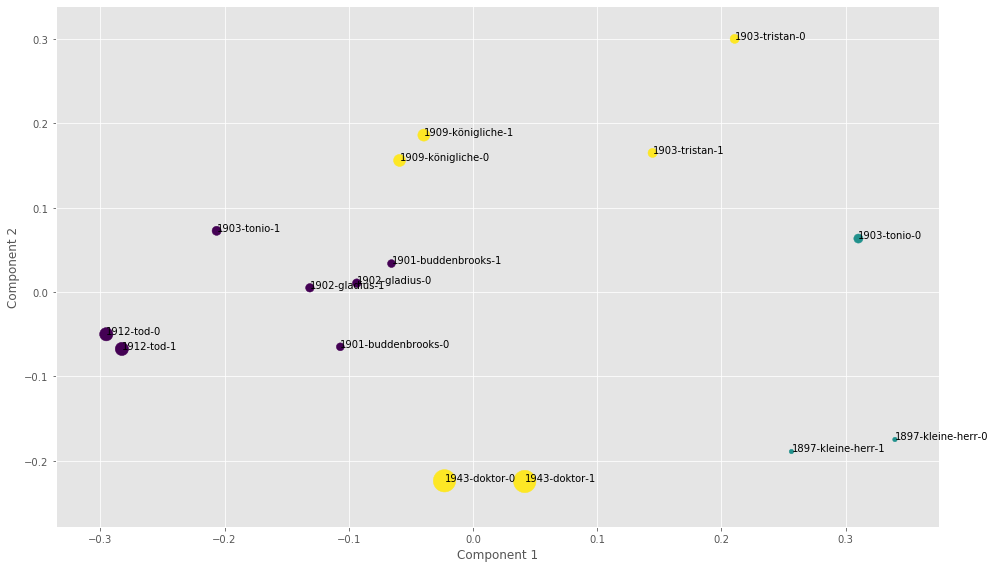

In [11]:
doAnalysis('mann')

# Scott

Lateness: 
0: 0.02209832403528391 1: 0.024757624882651562 2: 0.03560196133179794 3: 0.026253171363836925 4: 0.005380808608298836 5: 0.024305478758894487 6: 0.022553749275707656 7: 0.02122018885731672 8: 0.012273667495374577 9: 0.023004579628084006 
Periodicity: Adjusted rand score, BGM:  0.10867223094796144
Lateness:  0.02301137660084116
None
Average lateness:  0.021744891650291042
Average periodicities:  0.10284724911376777


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1818-heart-of-midlothian-1,0.151461,0.152068,-0.011003,-0.018944,-0.021874,0.216849,0,0,1818
1818-heart-of-midlothian-0,0.108537,0.172839,0.026353,-0.022140,-0.024793,0.208453,0,0,1818
1817-rob-roy-0,0.130677,-0.045415,0.126884,0.031314,0.065527,0.201278,0,0,1817
1823-st-ronans-well-1,0.149094,-0.036394,-0.105814,-0.049007,0.036421,0.196159,2,1,1823
1821-kenilworth-0,0.111278,-0.027296,-0.082164,0.087282,-0.031382,0.168766,2,1,1821
1831-castle-dangerous-1,-0.035194,0.023158,-0.107630,-0.054211,0.085686,0.153753,1,2,1831
1832-count-robert-0,-0.137526,0.027177,-0.014783,-0.022036,0.040454,0.148300,1,2,1832
1816-old-mortalit-0,-0.129951,-0.002732,0.040994,-0.050518,-0.014177,0.146042,1,0,1816
1816-antiquary-0,0.070437,-0.024402,0.102445,0.036989,0.049380,0.140920,0,0,1816
1814-waverly-0,-0.086713,-0.000669,0.051863,-0.059878,-0.066981,0.135208,2,0,1814


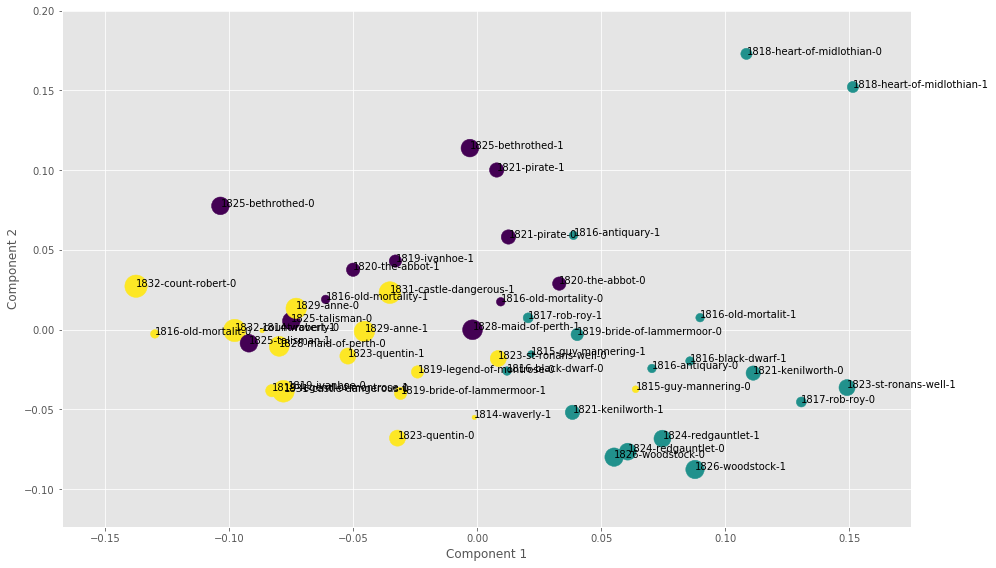

In [12]:
doAnalysis('scott')

# Mary Augusta Ward

Lateness: 
0: -0.12398139106161618 1: -0.14133439462008918 2: -0.14346367733828552 3: -0.11691575291886712 4: -0.12482266552906113 5: -0.13298263229243135 6: -0.14154960831293728 7: -0.1157286233850728 8: -0.1189840152712813 9: -0.12719673600371803 
Periodicity: Adjusted rand score, BGM:  0.18641932898202215


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Lateness:  -0.1271960087380505
None
Average lateness:  -0.12868852153362467
Average periodicities:  0.10280510294376569


,0,1,2,3,4,distance,bgm,initCats,pubDate
1881-milly-0,0.400418,-0.018700,-0.066004,-0.007440,0.004729,0.406347,1,0,1881
1881-milly-1,0.347700,0.049757,-0.037456,0.015506,-0.005417,0.353616,1,0,1881
1915-success-1,0.018588,0.172499,0.075987,-0.118632,-0.065384,0.232860,2,2,1915
1892-grieve-1,0.025159,0.041616,0.161583,0.120081,0.007777,0.207253,2,1,1892
1913-mating-0,-0.015117,-0.170460,0.070834,-0.071901,-0.018957,0.199579,0,2,1913
1920-harvest-0,-0.029134,-0.083922,-0.153708,0.008699,-0.008676,0.177958,0,2,1920
1892-grieve-0,0.009977,-0.026363,0.084269,0.141024,-0.039583,0.171320,2,1,1892
1915-success-0,-0.045465,0.093334,-0.016359,-0.069551,-0.101632,0.161902,2,2,1915
1916-connie-1,0.057171,-0.039616,0.138009,-0.042987,0.012042,0.160864,0,2,1916
1888-robert-0,-0.074966,0.107627,-0.062224,0.041448,0.006855,0.151130,0,0,1888


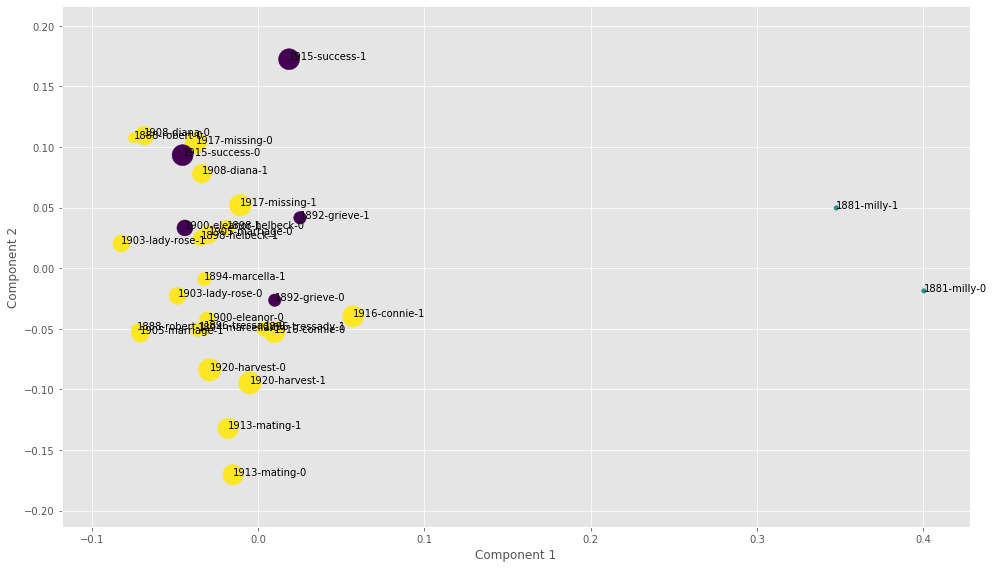

In [13]:
doAnalysis('ward')

Lateness: 
0: -0.010245511969012619 1: 0.10241744896364241 2: 0.0568581787814149 3: -0.04735123126626994 4: -0.02692298506280101 5: 0.03987355145585249 6: -0.007357897876484984 7: -0.0038045627113369035 8: -0.0001634388777498469 9: -0.023452872508474137 
Periodicity: Adjusted rand score, BGM:  0.1053290554816496
Lateness:  -0.023437577043512528
None
Average lateness:  0.007999376004861976
Average periodicities:  0.17739687235170254


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1856-the-shaving-of-shagpat-1,0.337422,-0.109537,0.003276,-0.033290,0.043556,0.358982,1,0,1856
1856-the-shaving-of-shagpat-0,0.295950,-0.063611,0.116412,-0.032839,0.016446,0.326394,1,0,1856
1879-the-egoist-0,-0.161723,-0.090323,0.018610,0.188782,0.029600,0.266784,0,1,1879
1857-farina-1,0.233819,-0.091618,0.031285,-0.007970,-0.022163,0.254162,1,0,1857
1861-evan-harrington-0,-0.171085,-0.073039,0.076199,-0.058122,-0.091343,0.228325,0,0,1861
1861-evan-harrington-1,-0.159712,-0.074438,0.067562,-0.057981,-0.077306,0.212018,0,0,1861
1877-the-house-on-the-beach-1,-0.122659,-0.073771,-0.012488,-0.027724,0.145948,0.206671,0,1,1877
1864-emilia-in-england-1,-0.139717,-0.055712,0.094616,0.087368,-0.038333,0.201691,0,0,1864
1857-farina-0,0.154767,-0.083573,0.068429,0.013605,-0.038201,0.193040,1,0,1857
1880-the-tragic-comedians-0,-0.010889,0.152226,0.043174,-0.092027,-0.056278,0.191811,2,1,1880


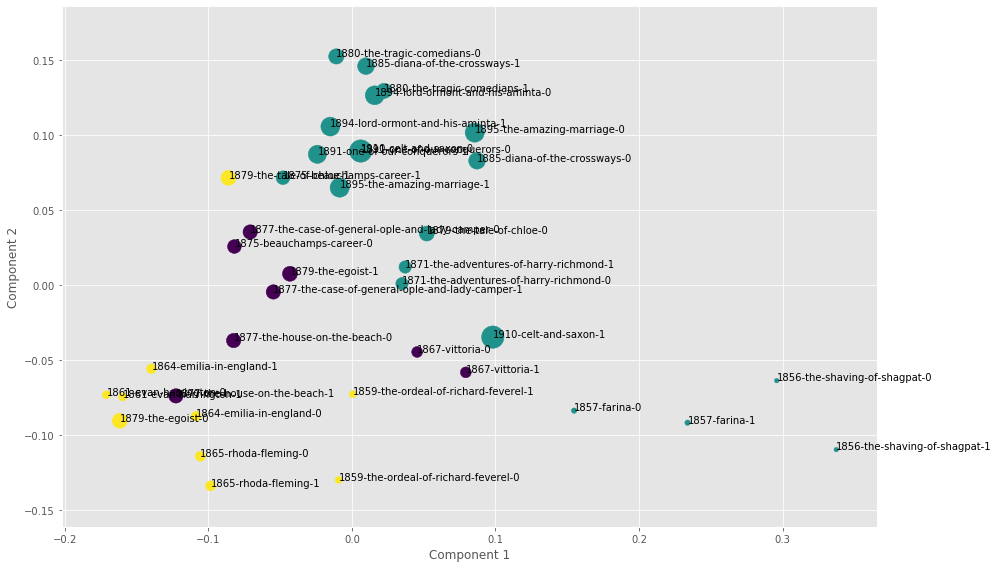

In [14]:
doAnalysis('meredith')

Lateness: 
0: 0.08332378994343813 1: 0.0723684645440397 2: 0.08921545296873226 3: 0.06393656553589679 4: 0.12306154204565221 5: 0.08277721085163968 6: 0.07380584647416163 7: 0.06131089366582697 8: 0.11967217167616265 9: 0.075456083298259 
Periodicity: Adjusted rand score, BGM:  0.1664220390651462
Lateness:  0.07545529279202508
None
Average lateness:  0.08449986643334427
Average periodicities:  0.17772563052296247


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1927-death-comes-for-the-archbishop-0,0.316354,-0.090206,-0.014299,0.002765,0.073384,0.337364,2,1,1927
1935-lucy-gayheart-1,-0.231605,-0.106478,0.113097,-0.013688,0.048232,0.283343,1,2,1935
1925-the-professors-house-1,0.060257,0.233608,0.055255,0.070734,-0.021403,0.258298,0,1,1925
1915-the-song-of-the-lark-1,-0.178245,0.029212,-0.090849,-0.114323,0.064737,0.241120,1,0,1915
1935-lucy-gayheart-0,-0.143846,0.043057,0.171036,-0.031265,0.018436,0.230469,0,2,1935
1927-death-comes-for-the-archbishop-1,0.193609,-0.023798,0.054569,0.070715,0.067724,0.224979,2,1,1927
1918-my-ántonia-1,-0.123938,-0.094687,-0.000303,0.108298,-0.097713,0.213547,1,0,1918
1940-sapphira-and-the-slave-girl-0,-0.001388,-0.200650,-0.012784,-0.046270,-0.009356,0.206529,2,2,1940
1926-my-mortal-enemy-1,-0.168430,-0.014551,-0.030404,0.105690,0.043059,0.206226,1,1,1926
1913-o-pioneers-0,-0.035698,0.089410,-0.145002,-0.007759,-0.054575,0.182573,1,0,1913


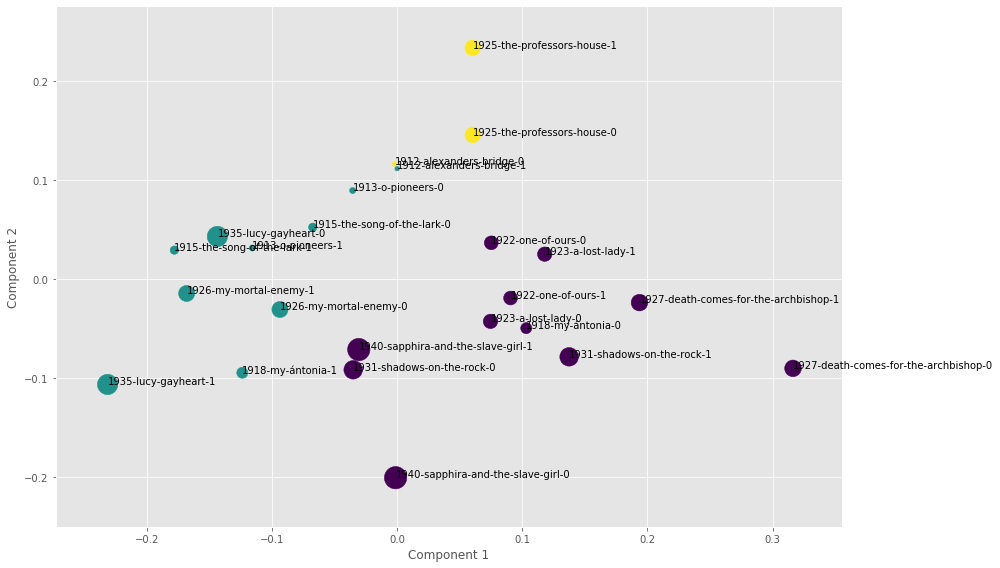

In [15]:
doAnalysis('cather')

Lateness: 
0: -0.029272396451620192 1: -0.004966016493495082 2: -0.023441399849286434 3: -0.039489701009547934 4: -0.02504559757976657 5: -0.002055883341197065 6: -0.010026079151624706 7: -0.03787258289073696 8: -0.029794114071211283 9: -0.003174279125335494 
Periodicity: Adjusted rand score, BGM:  0.2612752721617418
Lateness:  -0.0031742826275529684
None
Average lateness:  -0.020513808369561785
Average periodicities:  0.2459510789460133


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1902-grand-babylon-1,0.207123,0.075310,-0.024882,-0.088469,0.004749,0.238830,1,0,1902
1910-clayhanger-0,-0.079034,0.194466,0.044990,-0.003176,-0.053481,0.221264,0,1,1910
1902-grand-babylon-0,0.187760,0.041260,-0.014216,-0.095312,-0.005118,0.215102,1,0,1902
1928-strange-vanguard-0,0.133592,-0.037762,0.061537,0.124979,-0.039652,0.200628,2,2,1928
1930-imperial-1,0.031652,-0.111816,0.154775,-0.032257,0.014742,0.196769,2,2,1930
1928-strange-vanguard-1,0.120306,-0.014947,-0.007797,0.133012,-0.020860,0.181343,2,2,1928
1908-old-wives-1,-0.110904,-0.107653,-0.040390,-0.034681,-0.005078,0.163551,2,0,1908
1902-anna-0,-0.016531,-0.053199,-0.151361,0.003516,-0.009505,0.161606,2,0,1902
1911-card-1,-0.015940,0.094817,-0.110939,0.037405,0.051944,0.160153,0,1,1911
1923-riceyman-1,-0.043032,-0.148533,0.015182,-0.028314,-0.014823,0.158637,2,2,1923


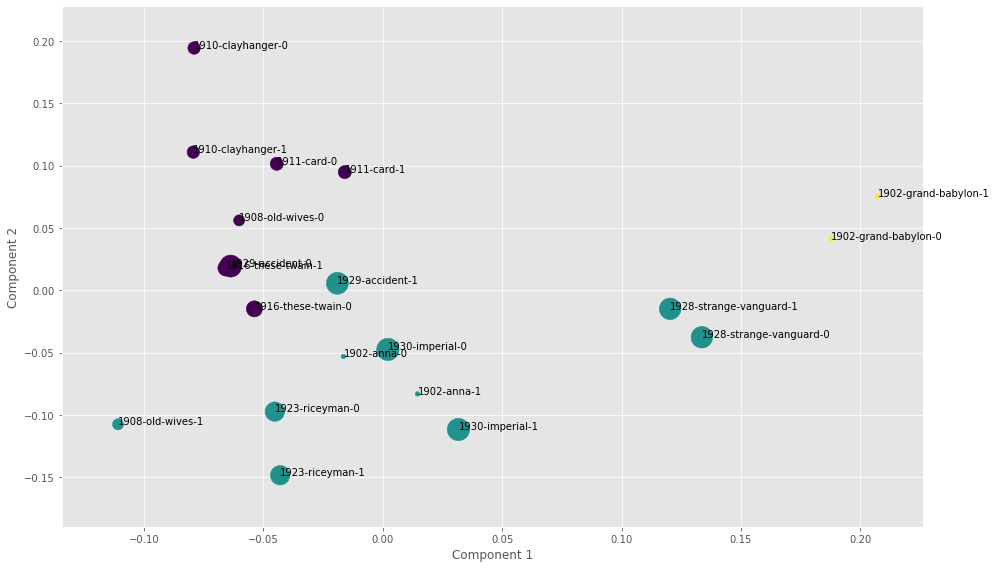

In [16]:
doAnalysis('bennett')

Lateness: 
0: 0.10432604457612003 1: 0.0940799366257887 2: 0.09024400696399679 3: 0.0847122294223025 4: 0.11014794337228254 5: 0.06649047421994556 6: 0.07812012899134636 7: 0.10937753303280083 8: 0.060956793003050166 9: 0.11497725298079695 
Periodicity: Adjusted rand score, BGM:  -0.015127866490575076
Lateness:  0.11497753012994326
None
Average lateness:  0.09134324389365671
Average periodicities:  0.04606945629548513


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1931-waves-1,0.382201,0.028797,-0.010569,0.020283,0.112238,0.400034,1,1,1931
1931-waves-0,0.361009,-0.005893,0.046028,0.003323,0.132474,0.387351,1,1,1931
1937-years-1,-0.303032,-0.164779,0.125991,0.105707,0.058805,0.386634,0,2,1937
1921-monday-or-tuesday-1,0.328542,-0.010325,0.023278,0.007554,-0.034394,0.331404,1,0,1921
1927-to-the-lighthouse-1,-0.298465,0.018478,-0.045740,-0.068266,0.101871,0.326425,2,1,1927
1937-years-0,-0.188135,-0.205782,-0.014155,0.106049,0.027207,0.299880,0,2,1937
1925-mrs-dalloway-1,-0.261677,0.027996,-0.131659,-0.013701,-0.033958,0.296536,1,1,1925
1919-night-and-day-0,-0.040612,0.219271,0.006214,0.098339,-0.092380,0.260715,2,0,1919
1919-night-and-day-1,-0.046260,0.181924,0.041506,0.123415,-0.057323,0.235534,2,0,1919
1941-between-the-acts-1,0.062810,-0.199281,-0.004834,-0.065249,-0.077596,0.232293,0,2,1941


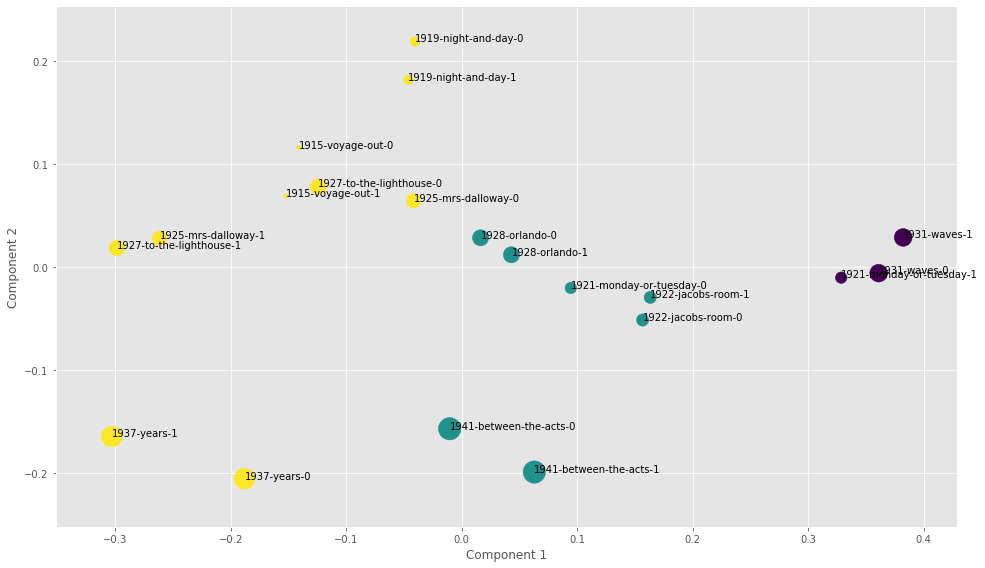

In [17]:
doAnalysis('woolf')

Lateness: 
0: -0.0009427057380669429 1: -0.013755001077745327 2: -0.0365862231343977 3: -0.020654323973013547 4: -0.006555671262078594 5: 0.0029757026735946074 6: 0.000655031581614493 7: -0.006143454928024414 8: -0.019801611244466014 9: -0.019360111031704555 
Periodicity: Adjusted rand score, BGM:  0.21231022713899023
Lateness:  -0.01935991243926319
None
Average lateness:  -0.012017463107136514
Average periodicities:  0.10624985181676476


/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/nix/store/3asb924hy4p82vdbcd353bmjwfkhzi5a-python3-3.7.6-env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


,0,1,2,3,4,distance,bgm,initCats,pubDate
1857-barchester-0,0.243613,0.077127,-0.019272,0.061220,-0.010902,0.263693,2,0,1857
1855-warden-0,0.234154,0.013800,0.035454,0.018297,0.002997,0.237948,2,0,1855
1855-warden-1,0.182503,0.012001,0.022796,0.013864,0.020022,0.185914,2,0,1855
1884-old-man-0,-0.153860,-0.003634,0.027764,0.096955,-0.024703,0.185654,1,2,1884
1858-doctor-thorne-1,-0.076149,0.064376,0.100510,0.005726,0.115097,0.182553,1,0,1858
1884-old-man-1,-0.131065,-0.079474,0.011424,0.071011,0.003198,0.169344,1,2,1884
1861-framley-0,-0.051933,0.121797,0.007969,-0.094985,-0.036651,0.167214,1,0,1861
1857-barchester-1,0.135568,0.016096,-0.002029,0.067863,-0.037834,0.157094,2,0,1857
1869-phineas-1,0.019013,-0.111631,0.044713,-0.062970,-0.049711,0.145804,0,1,1869
1877-american-senator-1,-0.100288,0.068023,-0.074078,0.012235,0.028623,0.145400,1,2,1877


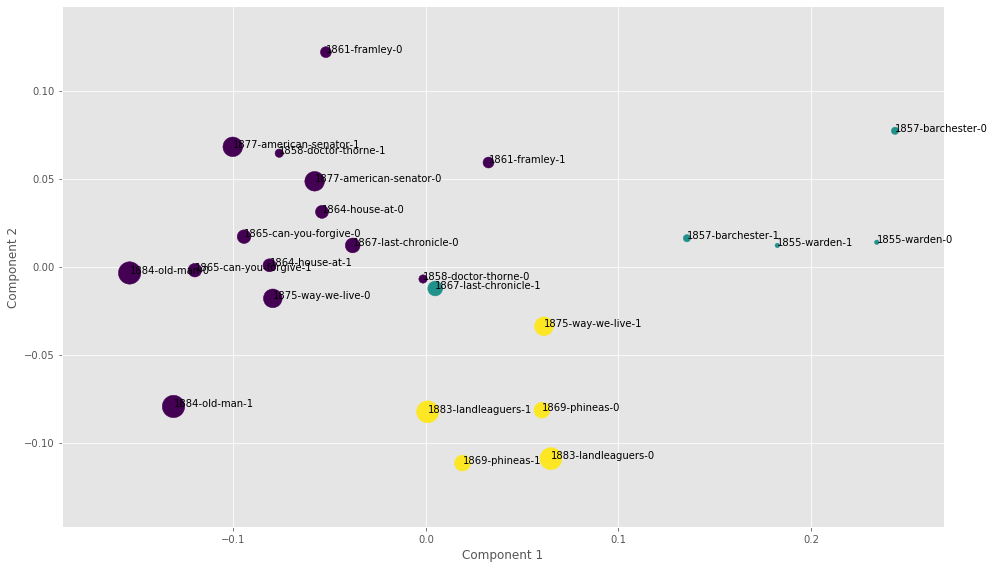

In [18]:
doAnalysis('trollope')

In [19]:
df = pd.DataFrame(authorTable)
df

,proust,dickens,conrad,genet,james,mann,scott,ward,meredith,cather,bennett,woolf,trollope
mean lateness,-0.094060,0.013392,0.012891,0.153675,0.061970,0.188811,0.021745,-0.128689,0.007999,0.084500,-0.020514,0.091343,-0.012017
mean periodicity,0.135309,0.180990,0.127526,0.112551,0.315414,0.048754,0.102847,0.102805,0.177397,0.177726,0.245951,0.046069,0.106250


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3629542e50>,
      dtype=object)

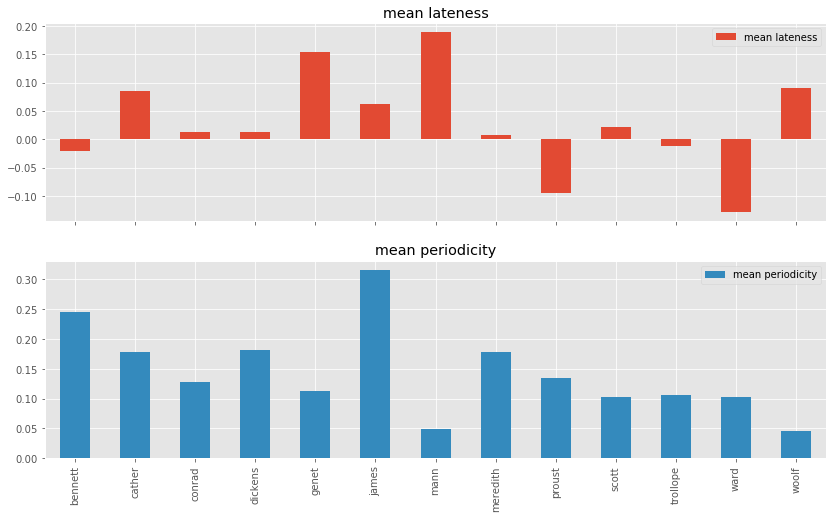

In [20]:
df.sort_index(axis=1).T.plot(kind='bar', subplots=True)

In [21]:
df.mean(axis=1)

mean lateness       0.029311
mean periodicity    0.144584
dtype: float64